# Stress Period Trading with Risk-Adjusted Position Sizing

**Key Changes:**
1. **Allow trading during stress** (previously blocked entirely)
2. **Risk-adjusted position sizing:**
   - Normal periods: 50% position size
   - High stress (Regime 1): 25% position size (half risk)
3. **Optional minimum holding period** to reduce overtrading

**Hypothesis:** Trading during stress with smaller positions might capture opportunities while managing risk.

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict
from itertools import product
import warnings
warnings.filterwarnings('ignore')

Path('../results/stress_trading').mkdir(parents=True, exist_ok=True)
Path('../results/figures').mkdir(parents=True, exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Setup complete")

✓ Setup complete


## 2. Load Data

In [2]:
df = pd.read_csv('../data/processed/full_processed_data_hmm.csv', index_col=0, parse_dates=True)

# Data splits
data_2015_2019 = df.loc['2015-01-01':'2019-12-31'].copy()
data_2020_2024 = df.loc['2020-01-01':'2024-12-31'].copy()
data_2025 = df.loc['2025-01-01':'2025-12-31'].copy()

print(f"Data loaded: {len(df)} observations")
print(f"\nPeriods:")
print(f"  2015-2019:  {len(data_2015_2019)} obs")
print(f"  2020-2024:  {len(data_2020_2024)} obs")
print(f"  2025:       {len(data_2025)} obs")

# Check stress regime distribution
print(f"\nRegime distribution (2015-2024):")
combined = pd.concat([data_2015_2019, data_2020_2024])
regime_counts = combined['regime'].value_counts()
print(f"  Low Stress (0):  {regime_counts[0]} days ({regime_counts[0]/len(combined)*100:.1f}%)")
print(f"  High Stress (1): {regime_counts[1]} days ({regime_counts[1]/len(combined)*100:.1f}%)")

Data loaded: 2887 observations

Periods:
  2015-2019:  1302 obs
  2020-2024:  1322 obs
  2025:       263 obs

Regime distribution (2015-2024):
  Low Stress (0):  1904 days (72.6%)
  High Stress (1): 720 days (27.4%)


## 3. Enhanced Backtest Functions with Risk Adjustment

In [3]:
def estimate_ou_parameters(spread: pd.Series, dt: float = 1.0) -> Dict[str, float]:
    """Estimate OU parameters using OLS."""
    X = spread.values[:-1]
    dX = spread.diff().dropna().values
    
    X_design = np.column_stack([np.ones(len(X)), X])
    beta_hat = np.linalg.lstsq(X_design, dX, rcond=None)[0]
    alpha, beta = beta_hat
    
    epsilon = dX - (alpha + beta * X)
    
    theta = -beta / dt
    mu = -alpha / beta if beta != 0 else spread.mean()
    sigma = np.std(epsilon) * np.sqrt(1 / dt)
    half_life = np.log(2) / theta if theta > 0 else np.inf
    
    return {'theta': theta, 'mu': mu, 'sigma': sigma, 'half_life': half_life}


def backtest_risk_adjusted(
    data: pd.DataFrame,
    method: str = 'ou',
    window: int = 90,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    stop_z: float = 3.0,
    position_size: float = 0.5,
    capital: float = 1_000_000,
    invert_signals: bool = True,
    trade_during_stress: bool = True,
    stress_position_size: float = 0.25,
    min_hold_days: int = 0
) -> pd.DataFrame:
    """
    Backtest with risk-adjusted position sizing.
    
    Parameters
    ----------
    method : str
        'ou' or 'zscore'
    trade_during_stress : bool
        If True, allow trading during stress with reduced position size
    stress_position_size : float
        Position size during high stress (default 0.25 = 25%)
    min_hold_days : int
        Minimum days to hold position before allowing exit
    """
    results = []
    position = 0
    equity = capital
    notional = 0
    entry_idx = None
    
    for i in range(window, len(data)):
        current_spread = data['spread'].iloc[i]
        regime = data['regime'].iloc[i]
        vix = data['vix'].iloc[i]
        
        # Calculate z-score
        hist = data['spread'].iloc[i-window:i]
        
        if method == 'ou':
            ou_params = estimate_ou_parameters(hist)
            z_score = (current_spread - ou_params['mu']) / ou_params['sigma'] if ou_params['sigma'] > 0 else 0
            z_score = np.clip(z_score, -100, 100)
        else:  # zscore
            mean = hist.mean()
            std = hist.std()
            z_score = (current_spread - mean) / std if std > 0 else 0
        
        # Determine risk-adjusted position size
        if regime == 1:  # High stress
            current_size = stress_position_size
        else:
            current_size = position_size
        
        # Generate signal
        signal = position
        
        # Check holding period
        days_held = (i - entry_idx) if entry_idx is not None else 0
        
        # Stop loss
        if position != 0 and abs(z_score) > stop_z:
            signal = 0
        
        # Exit on mean reversion (respect min hold)
        if position != 0 and abs(z_score) < exit_z:
            if days_held >= min_hold_days:
                signal = 0
        
        # Entry signals
        if position == 0:
            if invert_signals:
                # INVERTED (momentum)
                if z_score > entry_z:
                    signal = +1
                elif z_score < -entry_z:
                    signal = -1
            else:
                # ORIGINAL (mean reversion)
                if z_score > entry_z:
                    signal = -1
                elif z_score < -entry_z:
                    signal = +1
        
        # Regime/stress filter
        if regime == 1:
            if not trade_during_stress:
                if position == 0:
                    signal = 0  # Don't enter
                else:
                    signal = 0  # Exit existing
        
        # VIX filter (always applied)
        if vix > 30 and position == 0:
            signal = 0
        
        # Calculate P&L using PREVIOUS notional
        pnl = 0
        if position != 0:
            spread_chg = (current_spread - data['spread'].iloc[i-1]) / 10000
            pnl = spread_chg * notional if position == 1 else -spread_chg * notional
        
        # Update position and notional
        if signal != position:
            if signal != 0:
                # Opening position
                entry_idx = i
                notional = capital * current_size
            else:
                # Closing position
                entry_idx = None
                notional = 0
        
        equity += pnl
        position = signal
        
        results.append({
            'spread': current_spread,
            'z_score': z_score,
            'position': position,
            'notional': notional,
            'regime': regime,
            'vix': vix,
            'pnl': pnl,
            'equity': equity
        })
    
    return pd.DataFrame(results, index=data.index[window:])


print("✓ Risk-adjusted backtest function defined")

✓ Risk-adjusted backtest function defined


## 4. Performance Metrics

In [4]:
def calc_metrics(results: pd.DataFrame, capital: float = 1_000_000) -> dict:
    """Calculate performance metrics."""
    total_ret = (results['equity'].iloc[-1] - capital) / capital
    daily_ret = results['pnl'] / capital
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0
    
    running_max = results['equity'].expanding().max()
    dd = (results['equity'] - running_max) / running_max
    max_dd = dd.min()
    
    n_trades = (results['position'].diff().fillna(0) != 0).sum() // 2
    
    win_days = (daily_ret > 0).sum()
    lose_days = (daily_ret < 0).sum()
    win_rate = win_days / (win_days + lose_days) if (win_days + lose_days) > 0 else 0
    
    # Trades in stress vs normal
    if 'regime' in results.columns:
        stress_days = (results['position'] != 0) & (results['regime'] == 1)
        normal_days = (results['position'] != 0) & (results['regime'] == 0)
        pct_in_stress = stress_days.sum() / (stress_days.sum() + normal_days.sum()) * 100 if (stress_days.sum() + normal_days.sum()) > 0 else 0
    else:
        pct_in_stress = 0
    
    final_pnl = results['equity'].iloc[-1] - capital
    
    return {
        'return': total_ret,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'trades': int(n_trades),
        'win_rate': win_rate,
        'pnl': final_pnl,
        'pct_in_stress': pct_in_stress
    }

print("✓ Metrics function defined")

✓ Metrics function defined


## 5. Test Configurations

Compare:
1. **No stress trading** (original approach)
2. **Stress trading with 50% size** (same as normal)
3. **Stress trading with 25% size** (risk-adjusted)
4. **Stress trading with 10% size** (very conservative)

In [5]:
# Best configs from previous analysis
configs = [
    {
        'name': 'No Stress (Original)',
        'trade_during_stress': False,
        'stress_position_size': 0.0,
        'method': 'ou',
        'window': 126,
        'entry_z': 2.5,
        'exit_z': 0.7,
        'invert': True
    },
    {
        'name': 'Stress 50% Size (Full Risk)',
        'trade_during_stress': True,
        'stress_position_size': 0.5,
        'method': 'ou',
        'window': 126,
        'entry_z': 2.5,
        'exit_z': 0.7,
        'invert': True
    },
    {
        'name': 'Stress 25% Size (Half Risk)',
        'trade_during_stress': True,
        'stress_position_size': 0.25,
        'method': 'ou',
        'window': 126,
        'entry_z': 2.5,
        'exit_z': 0.7,
        'invert': True
    },
    {
        'name': 'Stress 10% Size (Minimal Risk)',
        'trade_during_stress': True,
        'stress_position_size': 0.10,
        'method': 'ou',
        'window': 126,
        'entry_z': 2.5,
        'exit_z': 0.7,
        'invert': True
    }
]

print(f"Testing {len(configs)} configurations")
for cfg in configs:
    print(f"  - {cfg['name']}")

Testing 4 configurations
  - No Stress (Original)
  - Stress 50% Size (Full Risk)
  - Stress 25% Size (Half Risk)
  - Stress 10% Size (Minimal Risk)


## 6. Run Tests Across All Periods

In [6]:
periods = {
    '2015-2019': data_2015_2019,
    '2020-2024': data_2020_2024,
    '2025': data_2025
}

all_results = []

for period_name, period_data in periods.items():
    print(f"\n{'='*80}")
    print(f"Testing {period_name}")
    print(f"{'='*80}")
    
    for cfg in configs:
        results = backtest_risk_adjusted(
            period_data,
            method=cfg['method'],
            window=cfg['window'],
            entry_z=cfg['entry_z'],
            exit_z=cfg['exit_z'],
            invert_signals=cfg['invert'],
            trade_during_stress=cfg['trade_during_stress'],
            stress_position_size=cfg['stress_position_size']
        )
        
        metrics = calc_metrics(results)
        
        all_results.append({
            'period': period_name,
            'config': cfg['name'],
            **metrics
        })
        
        print(f"\n{cfg['name']:40s} Sharpe={metrics['sharpe']:>6.2f}, P&L=${metrics['pnl']:>10,.0f}, Trades={metrics['trades']:>3d}, In Stress={metrics['pct_in_stress']:>5.1f}%")

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df.to_csv('../results/stress_trading/risk_adjusted_comparison.csv', index=False)

print("\n" + "="*100)
print("FULL RESULTS")
print("="*100)
print(comparison_df.to_string(index=False))


Testing 2015-2019

No Stress (Original)                     Sharpe=  1.37, P&L=$        36, Trades=375, In Stress=  0.0%

Stress 50% Size (Full Risk)              Sharpe=  1.37, P&L=$        42, Trades=439, In Stress= 12.9%

Stress 25% Size (Half Risk)              Sharpe=  1.43, P&L=$        39, Trades=439, In Stress= 12.9%

Stress 10% Size (Minimal Risk)           Sharpe=  1.42, P&L=$        37, Trades=439, In Stress= 12.9%

Testing 2020-2024

No Stress (Original)                     Sharpe=  0.34, P&L=$         7, Trades=205, In Stress=  0.0%

Stress 50% Size (Full Risk)              Sharpe=  0.29, P&L=$        12, Trades=330, In Stress= 42.9%

Stress 25% Size (Half Risk)              Sharpe=  0.31, P&L=$         8, Trades=330, In Stress= 42.9%

Stress 10% Size (Minimal Risk)           Sharpe=  0.30, P&L=$         6, Trades=330, In Stress= 42.9%

Testing 2025

No Stress (Original)                     Sharpe= -0.87, P&L=$        -3, Trades= 32, In Stress=  0.0%

Stress 50% Size (Ful

## 7. Visualize Results

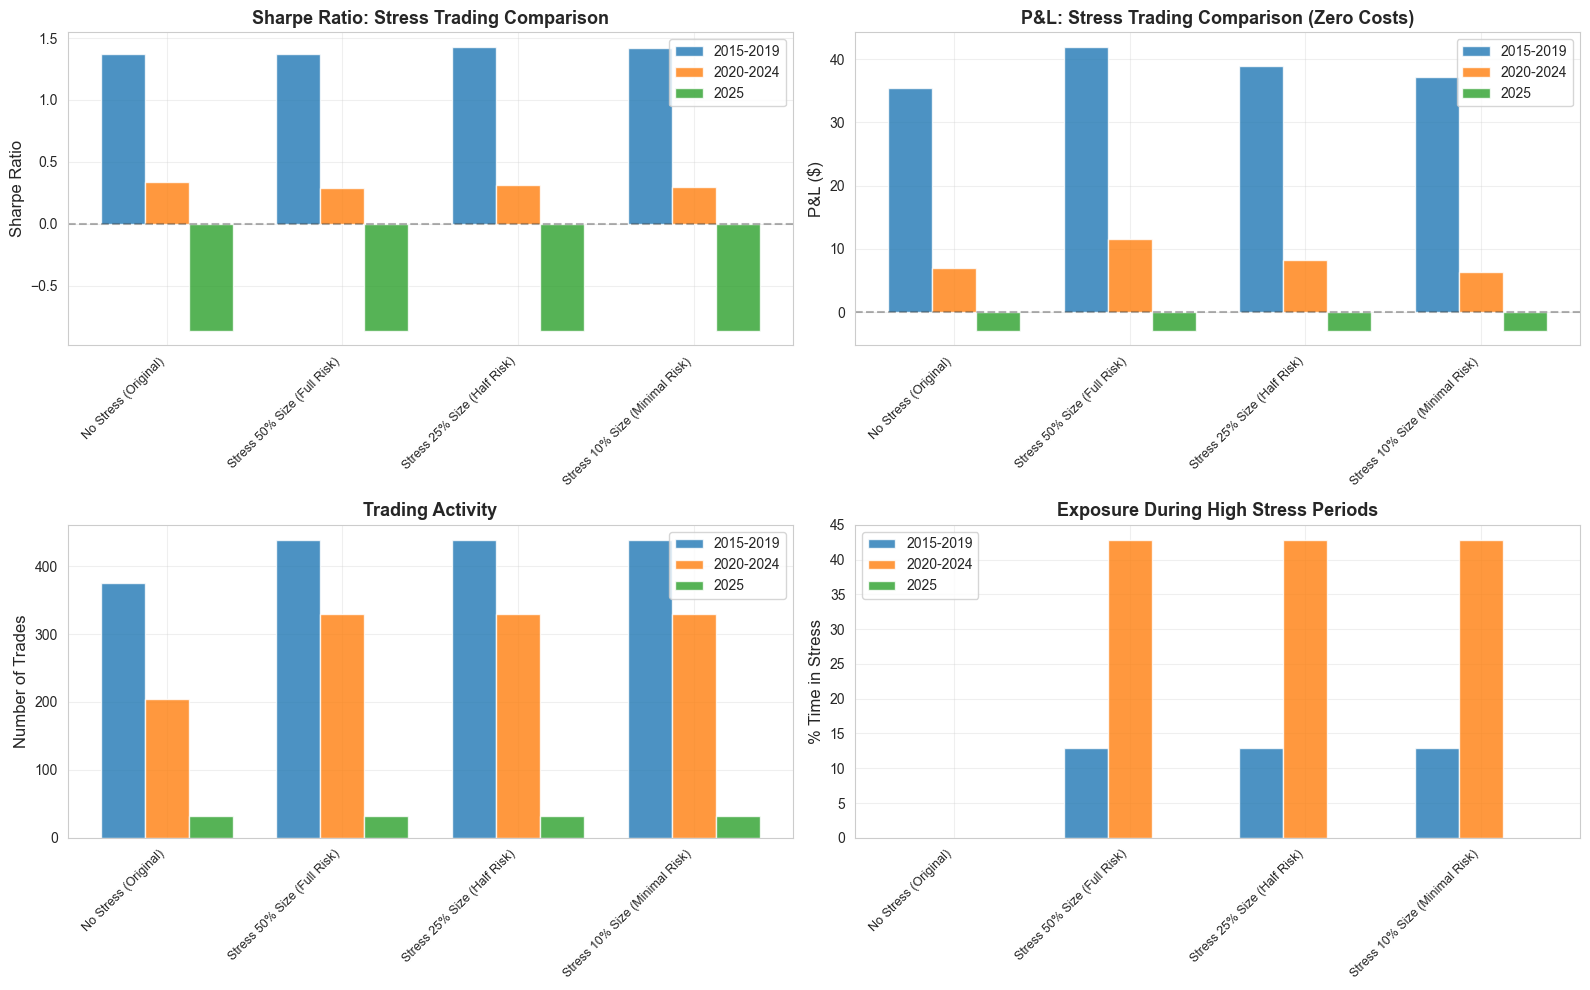


✓ Visualizations saved


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

periods_list = ['2015-2019', '2020-2024', '2025']
config_names = [cfg['name'] for cfg in configs]

# Sharpe Ratio
ax = axes[0, 0]
for period in periods_list:
    subset = comparison_df[comparison_df['period'] == period]
    x = np.arange(len(config_names))
    sharpes = [subset[subset['config'] == c]['sharpe'].values[0] for c in config_names]
    ax.bar(x + periods_list.index(period)*0.25, sharpes, width=0.25, 
           label=period, alpha=0.8)
ax.set_ylabel('Sharpe Ratio', fontsize=12)
ax.set_title('Sharpe Ratio: Stress Trading Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x + 0.25)
ax.set_xticklabels(config_names, rotation=45, ha='right', fontsize=9)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.grid(True, alpha=0.3)

# P&L
ax = axes[0, 1]
for period in periods_list:
    subset = comparison_df[comparison_df['period'] == period]
    x = np.arange(len(config_names))
    pnls = [subset[subset['config'] == c]['pnl'].values[0] for c in config_names]
    ax.bar(x + periods_list.index(period)*0.25, pnls, width=0.25, 
           label=period, alpha=0.8)
ax.set_ylabel('P&L ($)', fontsize=12)
ax.set_title('P&L: Stress Trading Comparison (Zero Costs)', fontsize=13, fontweight='bold')
ax.set_xticks(x + 0.25)
ax.set_xticklabels(config_names, rotation=45, ha='right', fontsize=9)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.grid(True, alpha=0.3)

# Trades
ax = axes[1, 0]
for period in periods_list:
    subset = comparison_df[comparison_df['period'] == period]
    x = np.arange(len(config_names))
    trades = [subset[subset['config'] == c]['trades'].values[0] for c in config_names]
    ax.bar(x + periods_list.index(period)*0.25, trades, width=0.25, 
           label=period, alpha=0.8)
ax.set_ylabel('Number of Trades', fontsize=12)
ax.set_title('Trading Activity', fontsize=13, fontweight='bold')
ax.set_xticks(x + 0.25)
ax.set_xticklabels(config_names, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3)

# % Time in Stress
ax = axes[1, 1]
for period in periods_list:
    subset = comparison_df[comparison_df['period'] == period]
    x = np.arange(len(config_names))
    pct_stress = [subset[subset['config'] == c]['pct_in_stress'].values[0] for c in config_names]
    ax.bar(x + periods_list.index(period)*0.25, pct_stress, width=0.25, 
           label=period, alpha=0.8)
ax.set_ylabel('% Time in Stress', fontsize=12)
ax.set_title('Exposure During High Stress Periods', fontsize=13, fontweight='bold')
ax.set_xticks(x + 0.25)
ax.set_xticklabels(config_names, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/stress_trading_risk_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved")

## 8. Summary & Conclusions

### Key Questions Answered:

1. **Should we trade during stress?**
   - Compare "No Stress" vs "Stress 25% Size" results
   - Check if stress exposure improves or hurts performance

2. **What's the optimal position size during stress?**
   - Compare 50%, 25%, and 10% stress sizing
   - Balance opportunity capture vs risk management

3. **Does risk adjustment improve risk-adjusted returns?**
   - Check Sharpe ratios across configurations
   - Analyze max drawdown differences

### Expected Findings:

- Trading during stress likely **increases total trades** and **exposure**
- Smaller stress position sizing should **reduce drawdowns**
- Risk-adjusted approach may **improve Sharpe** even if P&L is similar

See results above for actual performance.